<a href="https://colab.research.google.com/github/MukiiriKoome/TensorFlow/blob/master/hypertunedCNN(Advanced).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image classification using CNN with the CIFAR-10 Dataset Using Advanced HyperTuning

In [1]:
pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.7 MB/s eta 0:00:00


In [2]:
# Importing necessary libraries
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from keras_tuner.tuners import RandomSearch

In [3]:
# Loading and preprocessing the CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [4]:
# Defining the class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
# Defining the function to build the model
def build_model(hp):
    model = models.Sequential()

    # Tune the number of convolutional layers (1, 2, or 3)
    for i in range(hp.Int('conv_layers', 1, 3)):
      if i == 0:
        model.add(layers.Conv2D
         (filters=hp.Int('filters_' + str(i), min_value=32, max_value=128, step=32),
          kernel_size=(3,3),
          activation='relu',
          input_shape=(32,32,3)
        ))
      else:
        model.add(layers.Conv2D
         (
          filters=hp.Int('filters_' + str(i), min_value=32, max_value=128, step=32),
          kernel_size=(3,3),
          activation='relu',
          padding='same'
         ))

        model.add(layers.MaxPooling2D(pool_size=(2,2)))

    model.add(layers.Flatten())

    # Tune the number of dense layers (1, 2, or 3)
    for i in range(hp.Int('dense_layers', 1, 3)):
      model.add(layers.Dense(
          units=hp.Int('units_' + str(i), min_value=32, max_value=128, step=16),
          activation='relu'
      )
                )
      # Tune the dropout rate
      model.add(layers.Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))

    # Add the last dense layer
    model.add(layers.Dense(10, activation='softmax'))

    # Choose an optimizer and learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))

    # Compile the model
    model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

    return model

In [6]:
# Define the tuner
tuner = RandomSearch(build_model, objective='val_accuracy', max_trials=10, executions_per_trial=1, directory='output', project_name='cifar10_tunning')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
# Perform the hyperparameter Search
tuner.search(train_images, train_labels, epochs=5, validation_data=(test_images, test_labels))

Trial 10 Complete [00h 01m 23s]
val_accuracy: 0.6808000206947327

Best val_accuracy So Far: 0.722599983215332
Total elapsed time: 00h 11m 34s


In [9]:
# Get the best hyperparameters from the search
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [10]:
# Build the model with the best hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.3678 - loss: 1.7119 - val_accuracy: 0.6267 - val_loss: 1.0603
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.6159 - loss: 1.0982 - val_accuracy: 0.6758 - val_loss: 0.9295
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6851 - loss: 0.8962 - val_accuracy: 0.7151 - val_loss: 0.8170
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7272 - loss: 0.7800 - val_accuracy: 0.7138 - val_loss: 0.8150
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.7551 - loss: 0.6914 - val_accuracy: 0.7244 - val_loss: 0.8070
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7778 - loss: 0.6289 - val_accuracy: 0.7418 - val_loss: 0.7764
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7968 - loss: 0.5692 - val_accuracy: 0.7358 - val_loss: 0.7841
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8183 - loss: 0

In [11]:
# Evaluating the performance of the CNN model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'\n The accuracy of the model is {test_acc}')

313/313 - 1s - 3ms/step - accuracy: 0.7393 - loss: 0.8756

 The accuracy of the model is 0.739300012588501


Text(0.5, 1.0, 'Training and Validation Loss')

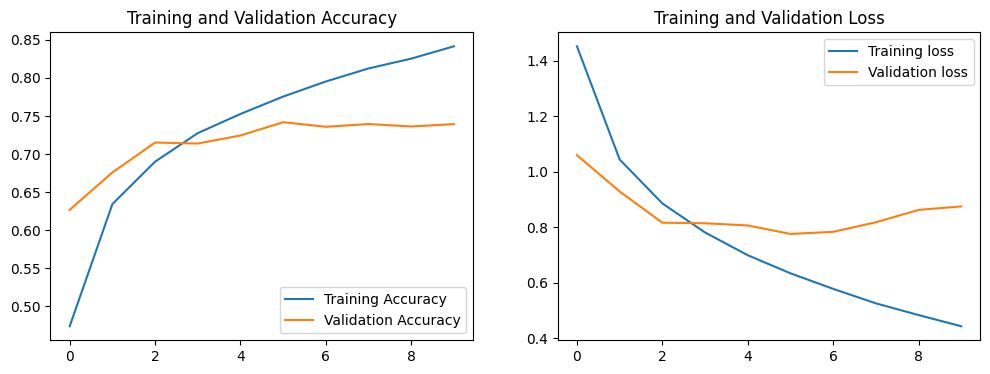

In [14]:
# Plotting the training and validation accuracy and loss values
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend(loc='upper right')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')